# Covid-19 Radiology Segmentation & Classification
COMP 478 Project
<br>
Jeremy Gaudet
<br>
ID: 40045224
<br>
April 25, 2021

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import scipy.ndimage as ndimage
from keras.preprocessing.image import ImageDataGenerator,array_to_img
import pandas as pd
import numpy as np
from PIL import Image
from packaging import version
import io
import tensorboard
import os
from glob import glob

In [2]:
# import sys
# from google.colab import drive
# drive.mount('/content/gdrive')
# sys.path.append('/content/gdrive/My Drive/COMP478 Project/')
# %cd /content/gdrive/My Drive/COMP478 Project/

### Global variables

In [3]:
PATH = '/Users/jeremygaudet/Downloads/COVID-19_Radiography_Dataset'
BATCH_SIZE = 32
IMAGE_SIZE = (64, 64)
IMAGE_WIDTH = IMAGE_SIZE[0]
IMAGE_HEIGHT = IMAGE_SIZE[1]

### Load the images

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=41,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 16932 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=41,
    label_mode="int",
    color_mode="grayscale"
)

Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


# DATA ANALYSIS

In this dataset, the chest x-ray images are divided into four classes:

In [6]:
CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)
print(CLASS_NAMES)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


The number of images in each class, however, is not evenly distrubuted, as can be seen in the following tables and graph. The biggest difference is between 'Viral Pneumonia' and 'Normal', where the latter has almost eight times as many instances as the former.

In [7]:
# # Get all training and validation labels and put them into separate lists
# # NOTE This can take a while
training_labels = np.concatenate([y for x, y in train_ds], axis=0)
validation_labels = np.concatenate([y for x, y in val_ds], axis=0)

In [8]:
# Use pandas to store the image count of each class in the training set
unique, counts = np.unique(training_labels, return_counts=True)
train_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])
# Do the same for validation set
unique, counts = np.unique(validation_labels, return_counts=True)
val_df = pd.DataFrame(dict(zip(CLASS_NAMES, counts)).items(), columns=["class", "image count"])

print('Distribution of training data:\n')
print(train_df)
print('\n\nDistribution of validation data:\n')
print(val_df)

Distribution of training data:

             class  image count
0            COVID         2902
1     Lung Opacity         4803
2           Normal         8168
3  Viral Pneumonia         1059


Distribution of validation data:

             class  image count
0            COVID          714
1     Lung Opacity         1209
2           Normal         2024
3  Viral Pneumonia          286


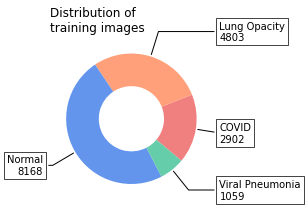

In [9]:
def display_distribution_donut(data_frame):
    fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(aspect="equal"))

    categories = data_frame['class']
    img_count = data_frame['image count']

    wedges, texts = ax.pie(
        img_count, 
        wedgeprops=dict(width=0.5), 
        startangle=-40, 
        colors=['lightcoral','lightsalmon', 'cornflowerblue', 'mediumaquamarine'])

    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(f'{categories[i]}\n{img_count[i]}', xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
    plt.title("Distribution of\ntraining images", loc='left')
    plt.show()

display_distribution_donut(train_df)

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 64, 64, 1)
(32,)


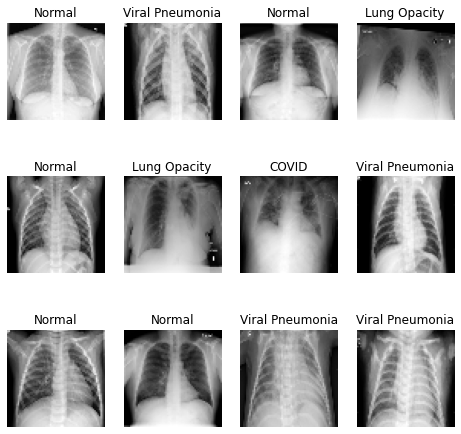

In [11]:
plt.figure(figsize=(8, 8))
for images, labels in val_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

# IMAGE PREPROCESSING

In [12]:
# AUTOTUNE = tf.data.AUTOTUNE

# def segment_diaphram2(images):
#     new_images = images
#     im_shape = images.shape
#     for count, img in enumerate(images):
#         # print(img.shape) # (64, 64, 1)
#         minimum, maximum, _, _ = ndimage.extrema(img)
#         # print(f'min: {minimum}, max: {maximum}')


#         blurred_image = ndimage.gaussian_filter(img, sigma=3)
#         img = tf.where(blurred_image > 50, 0, img)
        
#         # t = tf.constant(img)
#         # new_images.append(t)
#         # print(img)
#     # np.reshape(new_images, im_shape)
#     # new_images = tf.shape(im_shape, out_type=tf.float32)
#     return images

# def tf_segment_diaphram(image, label):
#     im_shape = image.shape
#     [image,] = tf.py_function(segment_diaphram2, inp=[image], Tout=[tf.float32])
#     image.set_shape(im_shape)
#     return image, label

# train_ds = train_ds.map(tf_segment_diaphram)

# def show(image, label):
#     plt.imshow(image, cmap='gray')
#     plt.title(CLASS_NAMES[label])
#     plt.axis('off')

# plt.figure(figsize=(8, 8))
# for image, label in train_ds.take(1):
#     for i in range(12):
#         ax = plt.subplot(3, 4, i + 1)
#         show(image[i], label[i])

## Remove the diaphram from the images (the lower, bright area)

In [13]:
def segment_diaphram(image):
    # If blurred pixel-value is greater than 195, make it black; otherwise, do not alter
    blurred_image = ndimage.gaussian_filter(image, sigma=3)
    image = tf.where(blurred_image > 195, 0, image) 
    return image

def tf_segment_diaphram(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(segment_diaphram, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds = train_ds.map(tf_segment_diaphram)

## Add randomly altered images to the training dataset

In [14]:
def reshape_image(image):
    image = tf.image.random_brightness(image, max_delta=.5)
    image = tf.image.random_contrast(image, .3, 1.7)
    image = tf.image.random_flip_left_right(image)
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=3, dtype=tf.float32)
    image = tf.add(image, noise)
    return image

def tf_reshape_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(reshape_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

train_ds_reshaped = train_ds.map(tf_reshape_image)
train_ds = train_ds.concatenate(train_ds_reshaped)
train_ds.shuffle(buffer_size=len(train_ds)*BATCH_SIZE)

<ShuffleDataset shapes: ((None, 64, 64, 1), (None,)), types: (tf.float32, tf.int32)>

## Displaying some newly altered images

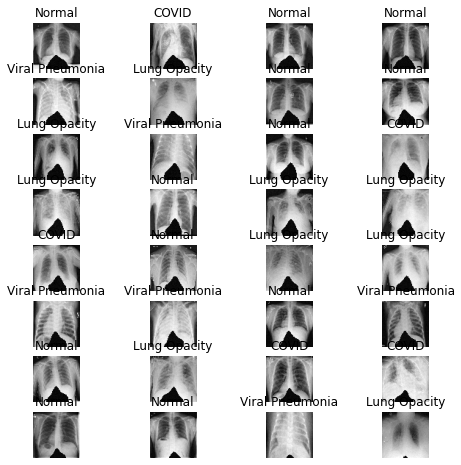

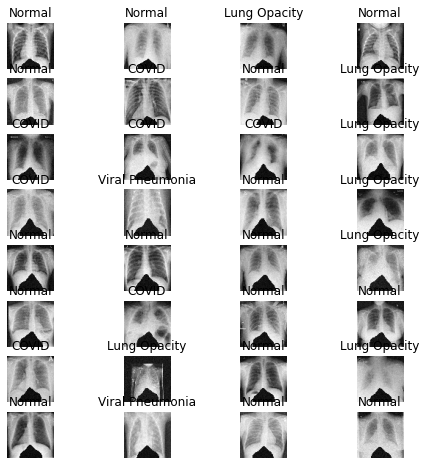

In [15]:
def show(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(CLASS_NAMES[label])
    plt.axis('off')

plt.figure(figsize=(8, 8))
for image, label in train_ds_reshaped.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        show(image[i], label[i])

plt.figure(figsize=(8, 8))
for image, label in train_ds_reshaped.take(2):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        show(image[i], label[i])

## Using keras to add more random variation to the training set

In [16]:
from keras import layers

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMAGE_HEIGHT, 
                                                              IMAGE_WIDTH,
                                                              1)),
    # layers.experimental.preprocessing.RandomRotation(0.01),
    # layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

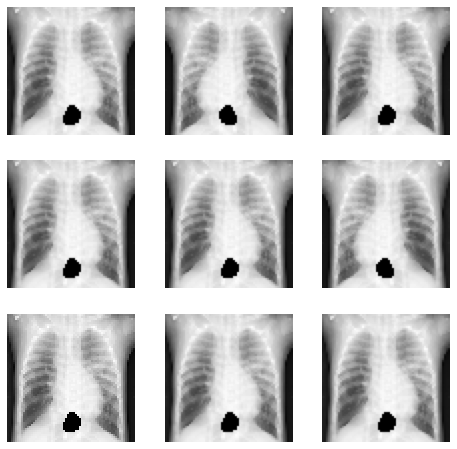

In [17]:
plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap="gray")
        plt.axis("off")

# CLASSIFICATION

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
model = tf.keras.Sequential([ 
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(NUM_CLASSES)
])

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 64, 64, 1)         0         
_________________________________________________________________
rescaling (Rescaling)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)      

In [21]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
1060/1060 [==============================] - 60s 56ms/step - loss: 0.8236 - accuracy: 0.6582 - val_loss: 0.6777 - val_accuracy: 0.7165
Epoch 2/10
1060/1060 [==============================] - 32s 30ms/step - loss: 0.5319 - accuracy: 0.7940 - val_loss: 0.4930 - val_accuracy: 0.8143
Epoch 3/10
1060/1060 [==============================] - 32s 30ms/step - loss: 0.4463 - accuracy: 0.8312 - val_loss: 0.4483 - val_accuracy: 0.8349
Epoch 4/10
1060/1060 [==============================] - 32s 30ms/step - loss: 0.3942 - accuracy: 0.8481 - val_loss: 0.4291 - val_accuracy: 0.8524
Epoch 5/10
1060/1060 [==============================] - 31s 30ms/step - loss: 0.3602 - accuracy: 0.8624 - val_loss: 0.3982 - val_accuracy: 0.8656
Epoch 6/10
1060/1060 [==============================] - 32s 30ms/step - loss: 0.3259 - accuracy: 0.8774 - val_loss: 0.4306 - val_accuracy: 0.8592
Epoch 7/10
1060/1060 [==============================] - 32s 31ms/step - loss: 0.3136 - accuracy: 0.8809 - val_loss: 0.4063 -

# RESULTS

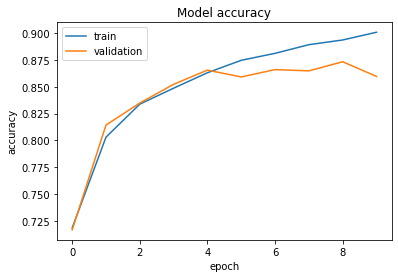

In [33]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)

In [45]:
def plot_learning_rate(hist):
    plt.plot(hist.history["lr"])
    plt.title("Learning rate during training")
    plt.ylabel("Learning Rate")
    plt.xlabel("epoch")
    plt.show()

plot_learning_rate(hist)

KeyError: 'lr'

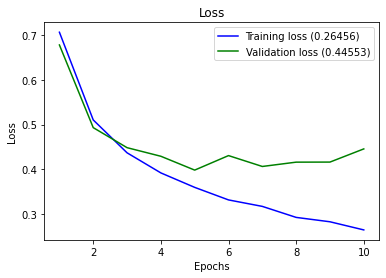

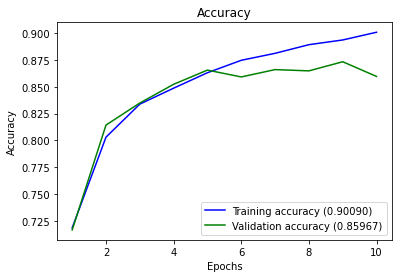

In [44]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(hist)

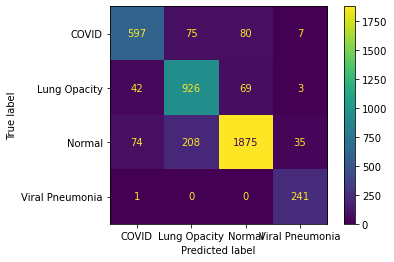


                  precision    recall  f1-score   support

          COVID       0.79      0.84      0.81       714
   Lung Opacity       0.89      0.77      0.82      1209
         Normal       0.86      0.93      0.89      2024
Viral Pneumonia       1.00      0.84      0.91       286

       accuracy                           0.86      4233
      macro avg       0.88      0.84      0.86      4233
   weighted avg       0.86      0.86      0.86      4233



In [23]:
def validation_data_categories(test_images):
    y_pred = model.predict(test_images)
    predicted_cat = tf.argmax(y_pred, axis=1)
    true_cat = tf.concat([y for x, y in test_images], axis=0)
    return true_cat, predicted_cat

def plot_confusion_matrix(true_cat, predicted_cat):
    cm = confusion_matrix(predicted_cat, true_cat)
    display = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES).plot()
    plt.show()

# Show the confusion matrix and the report
true_cat, pred_cat = validation_data_categories(val_ds)
plot_confusion_matrix(true_cat, pred_cat)
print('\n', classification_report(true_cat, pred_cat, target_names=CLASS_NAMES))

This image is Normal with 97.89% confidence


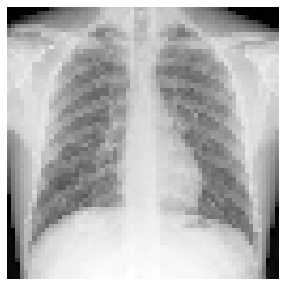

In [28]:
test_image_path = "/Users/jeremygaudet/Downloads/istockphoto-173883249-612x612.jpg"
# test_image_path = "/Users/jeremygaudet/Downloads/c3-1-e1586266398823.jpg.webp"
# test_image_path = "/Users/jeremygaudet/Downloads/normal-lung-xray-15x10-by-Yale-Rosen.jpg"
# test_image_path = "/Users/jeremygaudet/Desktop/Screen Shot 2021-04-23 at 9.28.57 AM.png"

img = keras.preprocessing.image.load_img(test_image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, 1), color_mode='grayscale')

# Plot image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.axis("off")

# Load a model
# model_256 = keras.models.load_model('models/covid_lung_model_256_preprocess_drop_big.h5')

# Preprocess image
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# Make predictions on images
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
# Get index for highest confidence class
idx = np.argmax(score)

print(f'This image is {CLASS_NAMES[idx]} with {score[idx]*100:0.2f}% confidence')

In [25]:
# Save the entire model to a HDF5 file.
# !mkdir models/
# model.save('models/covid_lung_model_256_preprocess_drop_big.h5')